In [6]:
import cv2
import torch
from PIL import Image
from t_diffusers.unet_2d_condition import UNet2DConditionModel

from diffusers import AutoencoderKL, DDPMScheduler

from pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from IPython.display import display

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float32,
)
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter_sd15.safetensors",
    ],
)
pipe.set_ip_adapter_scale(0.4)

text_mask_image = cv2.imread("./assets/mask_1.png") ## 수용님이 만드신 마스크 이미지 혹은 넘파이 배열이 들어가야합니다.

input_image = Image.open("./assets/original_input.jpeg").convert("RGB").resize((512, 512))

pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
generator = torch.Generator(device="cuda").manual_seed(42)
pipe.to("cuda")
output = pipe(
    prompt="a cat with a sign board 'bear bear bear'",
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image = input_image,
    width=512,
    height=512,
    guidance_scale=7,
    generator=generator,
).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

latent shape torch.Size([1, 4, 64, 64])
prompt_embeds shape or enc hidden state torch.Size([2, 77, 768])
feature_mask shape torch.Size([1, 1, 64, 64])
masked_feature shape torch.Size([1, 4, 64, 64])
segmentation_mask shape torch.Size([1, 1, 256, 256])


  0%|          | 0/50 [00:00<?, ?it/s]

attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024])
IP-Adapter here!  2 torch.Size([2, 77, 768])
attention_mask:  None
added_cond_kwargs
image_embeds_shape:  torch.Size([2, 1, 1024

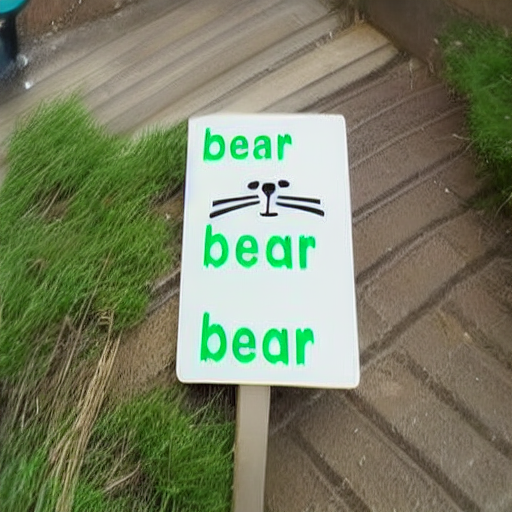

In [7]:
display(output)